In [95]:
# Step 0: Setup & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.decomposition import PCA

# Display options
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Path and target (change if needed)
DATA_PATH = r"c:\Users\Admin\Documents\EXCELR\DS Assignments\@\Pharma_Industry.csv"
TARGET_COL = "Drug Response"   # change if your target column has another name

# Load
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


Loaded: c:\Users\Admin\Documents\EXCELR\DS Assignments\@\Pharma_Industry.csv
Shape: (500, 6)
Columns: ['Drug Dosage (mg)', 'Systolic Blood Pressure (mmHg)', 'Heart Rate (BPM)', 'Liver Toxicity Index (U/L)', 'Blood Glucose Level (mg/dL)', 'Drug Response']


**Step 1: EDA - basic info, missing, describe**

In [96]:
print("\n--- HEAD ---")
display(df.head())


--- HEAD ---


,Drug Dosage (mg),Systolic Blood Pressure (mmHg),Heart Rate (BPM),Liver Toxicity Index (U/L),Blood Glucose Level (mg/dL),Drug Response
0,-0.128538,0.303280,-1.881849,0.258286,-0.792011,1
1,-1.846188,2.865142,-0.929511,2.866786,-0.719447,1
2,-1.252393,-1.541613,0.363632,-0.325370,0.191314,0
3,1.992515,-1.142779,-0.766657,0.975286,-0.823355,1
4,0.377100,0.538410,-0.029263,1.896015,-0.960130,1


In [97]:
print("\n--- DTYPE & NON-NULL ---")
display(pd.DataFrame({'dtype': df.dtypes, 'non_null': df.count()}))


--- DTYPE & NON-NULL ---


,dtype,non_null
Drug Dosage (mg),float64,500
Systolic Blood Pressure (mmHg),float64,500
Heart Rate (BPM),float64,500
Liver Toxicity Index (U/L),float64,500
Blood Glucose Level (mg/dL),float64,500
Drug Response,int64,500


In [98]:
print("\n--- MISSING VALUES ---")
print(df.isnull().sum())


--- MISSING VALUES ---
Drug Dosage (mg)                  0
Systolic Blood Pressure (mmHg)    0
Heart Rate (BPM)                  0
Liver Toxicity Index (U/L)        0
Blood Glucose Level (mg/dL)       0
Drug Response                     0
dtype: int64


In [99]:
# auto-detect target if specified not present
if TARGET_COL not in df.columns:
    # choose first binary column that looks like 0/1
    for col in df.columns:
        if df[col].nunique() == 2:
            TARGET_COL = col
            print(f"Auto-detected target: {TARGET_COL}")
            break

# Ensure target exists
assert TARGET_COL in df.columns, "Target column not found - set TARGET_COL correctly."

# Value counts of target
print("\nTarget distribution:")
print(df[TARGET_COL].value_counts())


Target distribution:
Drug Response
1    260
0    240
Name: count, dtype: int64


In [100]:
# Describe numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)
print("\nNumeric features:", numeric_cols)
display(df[numeric_cols].describe().T)


Numeric features: ['Drug Dosage (mg)', 'Systolic Blood Pressure (mmHg)', 'Heart Rate (BPM)', 'Liver Toxicity Index (U/L)', 'Blood Glucose Level (mg/dL)']


,count,mean,std,min,25%,50%,75%,max
Drug Dosage (mg),500.0,-0.037761,0.979891,-3.019512,-0.642003,-0.019340,0.641151,2.949094
Systolic Blood Pressure (mmHg),500.0,0.214957,1.247567,-3.773897,-0.565168,0.201532,0.951375,4.111751
Heart Rate (BPM),500.0,0.062871,0.971978,-2.940389,-0.648157,0.027732,0.710774,3.193108
Liver Toxicity Index (U/L),500.0,0.054398,0.986001,-3.401277,-0.586085,-0.065661,0.633914,3.373269
Blood Glucose Level (mg/dL),500.0,-0.171863,0.983765,-3.110431,-0.797715,-0.108106,0.513555,2.518023


**Step 2 — Distributions & correlations (histograms, boxplots, density, corr)**

<Figure size 1200x800 with 0 Axes>

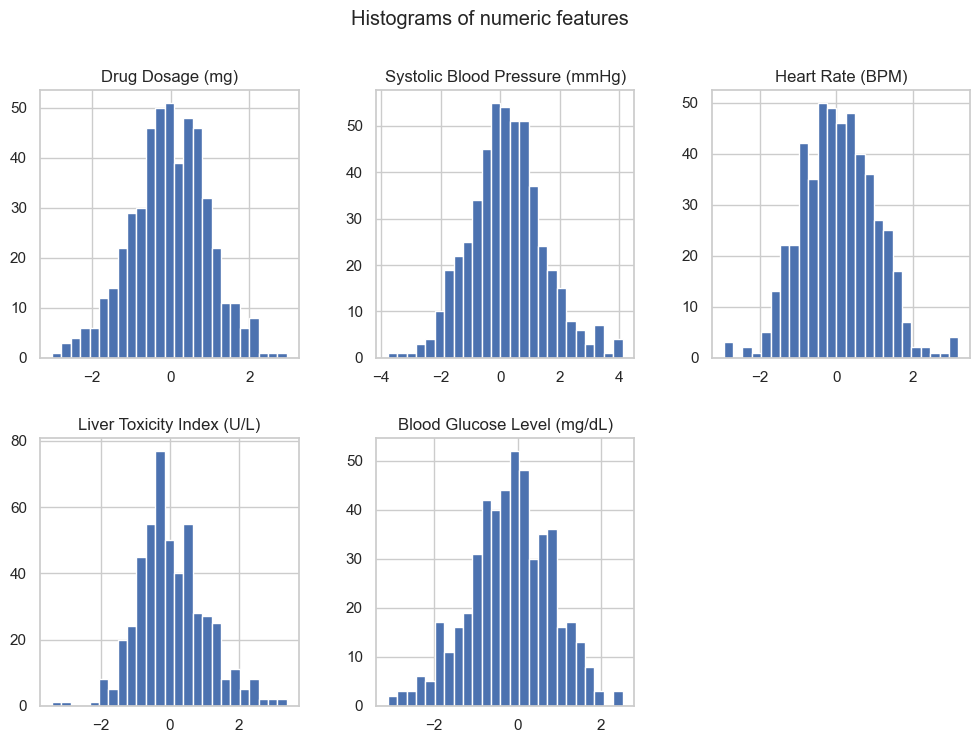

In [101]:
# Histograms
plt.figure(figsize=(12, 8))
df[numeric_cols].hist(bins=25, figsize=(12,8), layout=(int(np.ceil(len(numeric_cols)/3)), 3))
plt.suptitle("Histograms of numeric features")
plt.show()

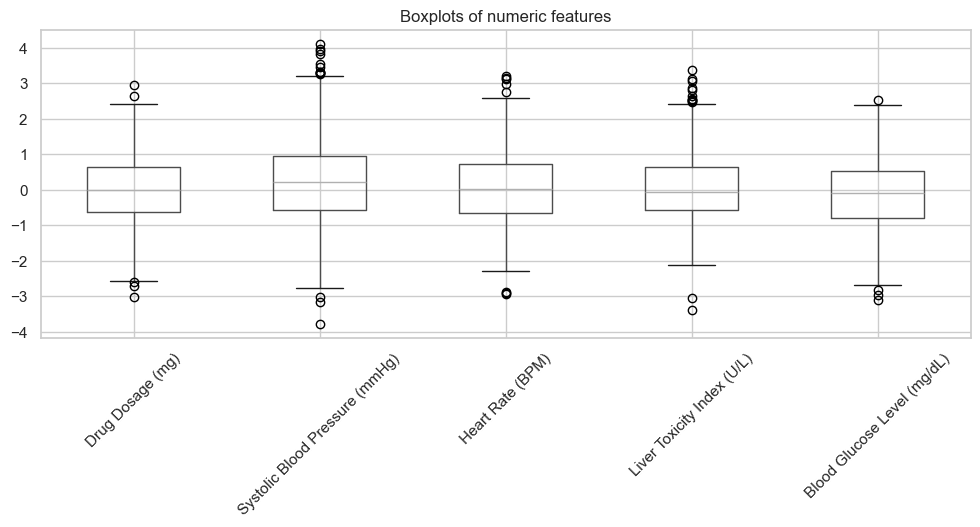

In [102]:
# Boxplots
plt.figure(figsize=(12, 4))
df[numeric_cols].boxplot(rot=45)
plt.title("Boxplots of numeric features")
plt.show()

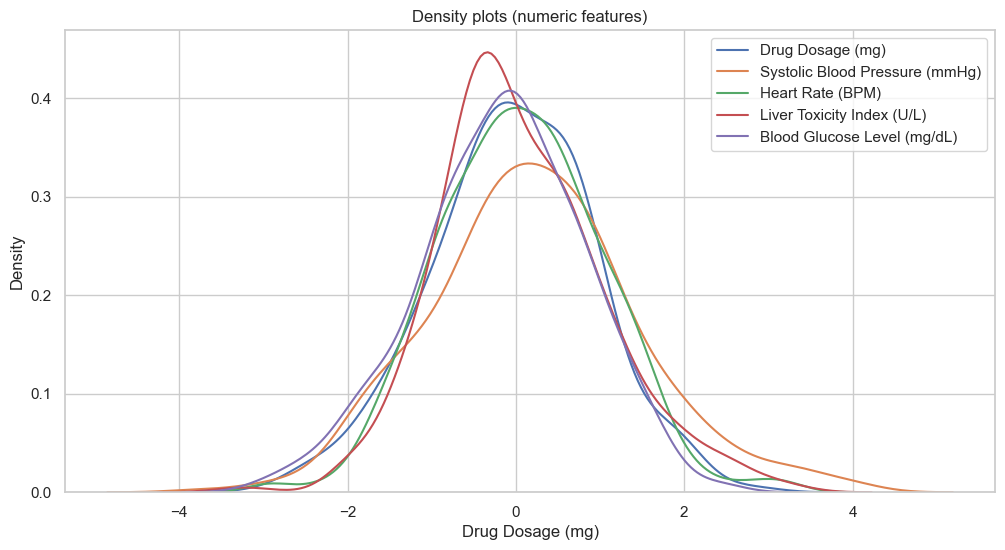

In [103]:
# Density plots
plt.figure(figsize=(12, 6))
for col in numeric_cols:
    sns.kdeplot(df[col].dropna(), label=col)
plt.title("Density plots (numeric features)")
plt.legend()
plt.show()

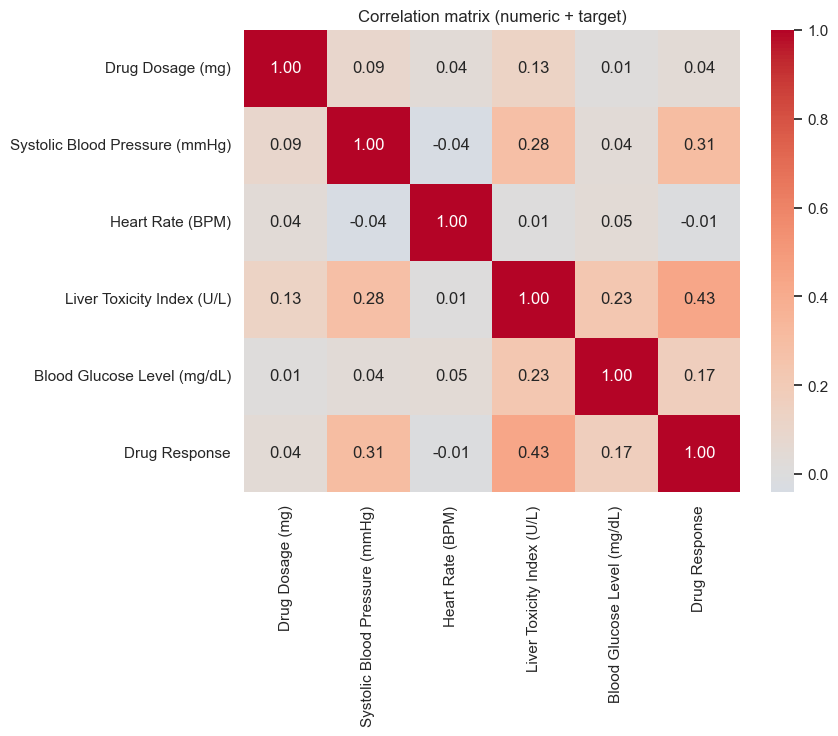


Features most correlated with target (abs desc):


,corr
Liver Toxicity Index (U/L),0.434722
Systolic Blood Pressure (mmHg),0.305226
Blood Glucose Level (mg/dL),0.169342
Drug Dosage (mg),0.043457
Heart Rate (BPM),-0.009715


In [104]:
# Correlation heatmap (including target)
corr = df[numeric_cols + [TARGET_COL]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation matrix (numeric + target)")
plt.show()

# Show features most correlated with target
corr_with_target = corr[TARGET_COL].drop(index=TARGET_COL).sort_values(key=lambda x: x.abs(), ascending=False)
print("\nFeatures most correlated with target (abs desc):")
display(corr_with_target.to_frame(name='corr'))

**Preprocessing (encoding, imputation, train/test split, scaling)**

In [105]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].copy()

# Encode categorical columns if any
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical cols:", cat_cols)
if len(cat_cols) > 0:
    # Use get_dummies for simplicity (drop_first optional)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Impute missing numeric columns with median, categorical (if any left) with mode
for col in X.columns:
    if X[col].isnull().any():
        if np.issubdtype(X[col].dtype, np.number):
            X[col].fillna(X[col].median(), inplace=True)
        else:
            X[col].fillna(X[col].mode().iloc[0], inplace=True)

# Ensure y numeric 0/1 (map common textual labels)
if not np.issubdtype(y.dtype, np.number):
    y_map = {}
    for val in y.dropna().unique():
        s = str(val).strip().lower()
        if s in ('1','positive','pos','yes','y','true','t','respond'):
            y_map[val] = 1
        elif s in ('0','negative','neg','no','n','none','false','f','no response'):
            y_map[val] = 0
    if y_map:
        y = y.map(y_map).astype(int)
    else:
        # fallback: label encode
        y = LabelEncoder().fit_transform(y)


Categorical cols: []


In [106]:
# Train/test split with stratify
stratify_arg = y if (y.nunique()>1 and y.value_counts().min()>1) else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_arg)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (400, 5) Test shape: (100, 5)


In [107]:
# Scale features (store scaler for later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Visualization: pairplot / scatter of top correlated features & class balance**

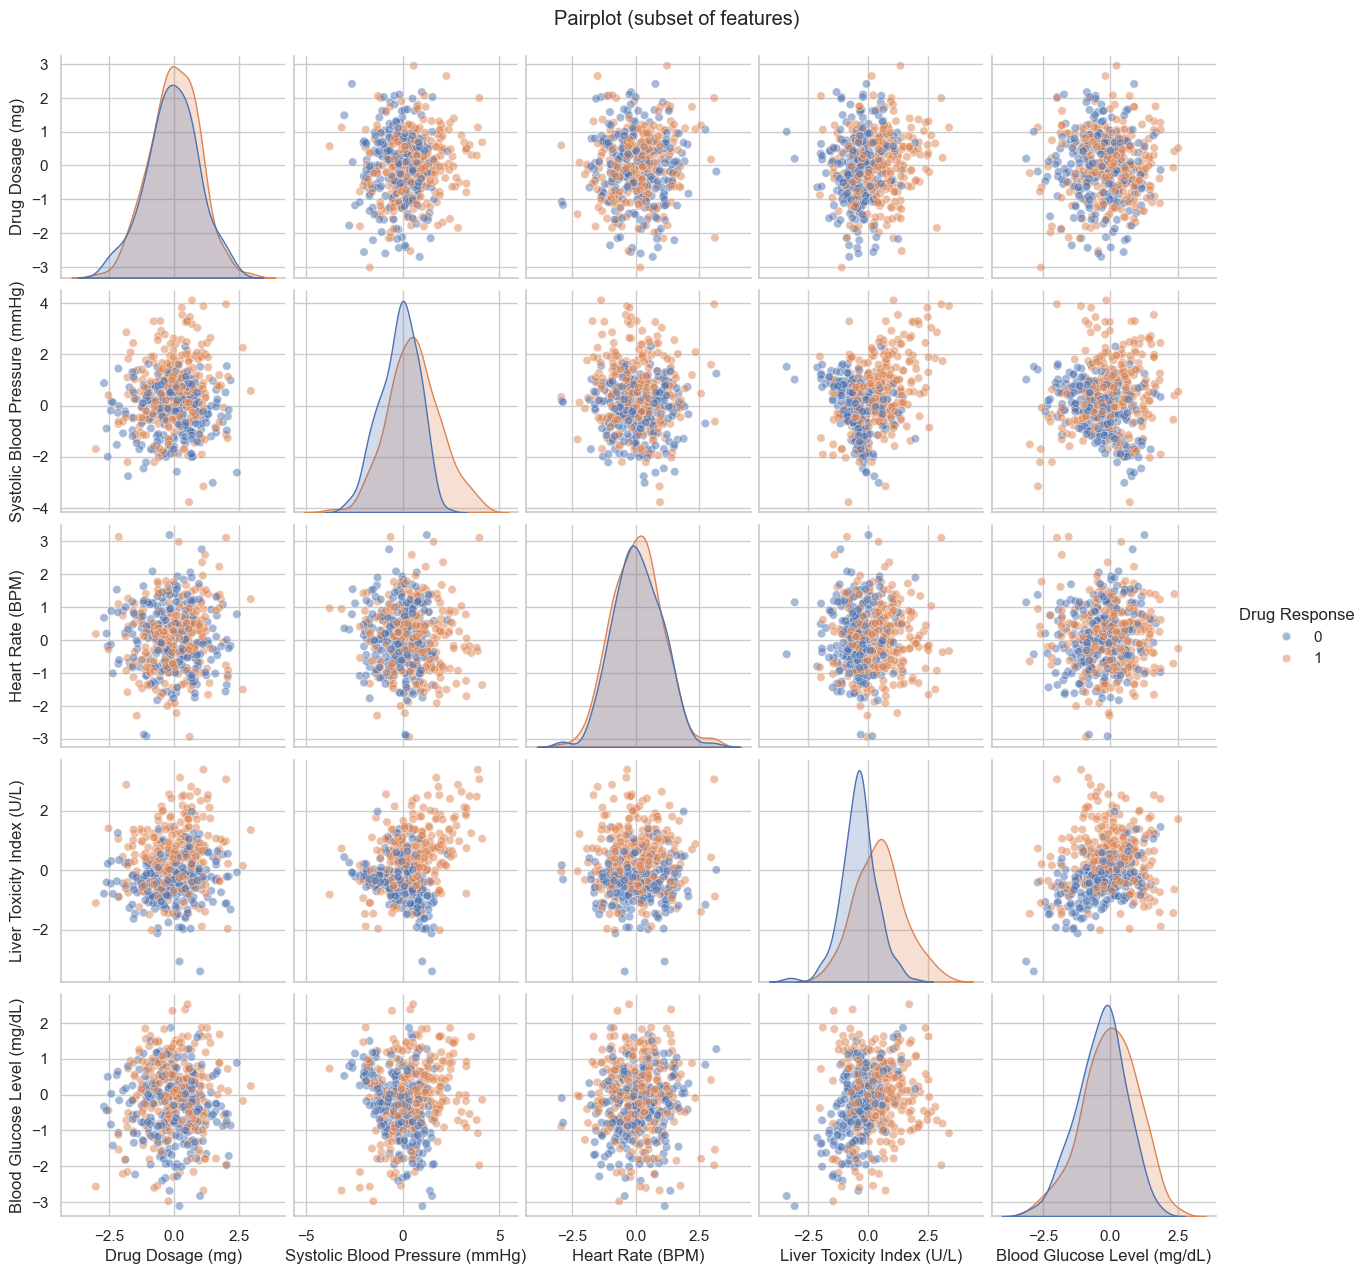

In [108]:
# Pairplot (use subset if many features)
plot_cols = numeric_cols[:6] if len(numeric_cols) > 6 else numeric_cols
sns.pairplot(pd.concat([df[plot_cols], df[TARGET_COL]], axis=1), hue=TARGET_COL, diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot (subset of features)", y=1.02)
plt.show()

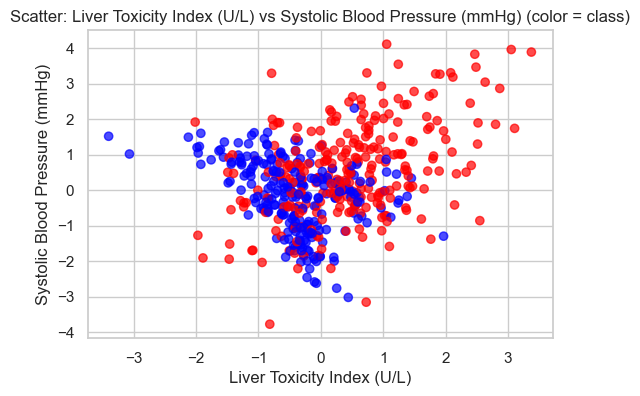

In [109]:
# Scatter between top 2 correlated features (if exist)
top_feats = corr_with_target.index[:2].tolist()
if len(top_feats) >= 2:
    plt.figure(figsize=(6,4))
    plt.scatter(X[top_feats[0]], X[top_feats[1]], c=y, cmap='bwr', alpha=0.7)
    plt.xlabel(top_feats[0]); plt.ylabel(top_feats[1])
    plt.title(f"Scatter: {top_feats[0]} vs {top_feats[1]} (color = class)")
    plt.show()

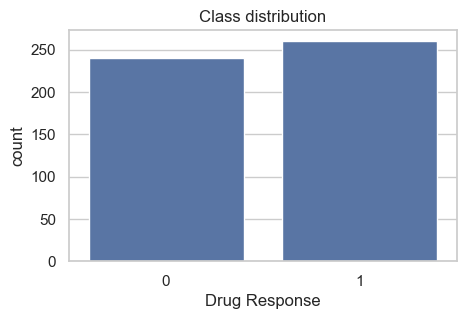

In [110]:
# Class distribution plot
plt.figure(figsize=(5,3))
sns.countplot(x=y)
plt.title("Class distribution")
plt.show()

**Step 5 — Baseline SVM (train + evaluate)**

In [111]:
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # optional: we already scaled above; keep for pipeline
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
])
baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

In [112]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1-score:", f1_score(y_test, y_pred, zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.77
Precision: 0.7543859649122807
Recall: 0.8269230769230769
F1-score: 0.7889908256880734

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        48
           1       0.75      0.83      0.79        52

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



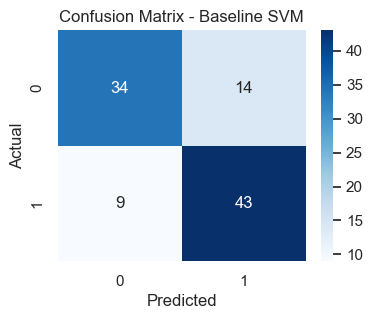

In [113]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline SVM")
plt.show()

**Step 6 — Visualization of SVM results (PCA 2D + decision regions)**

In [114]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train SVM in PCA space for visualization
svm_pca = SVC(kernel='rbf', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


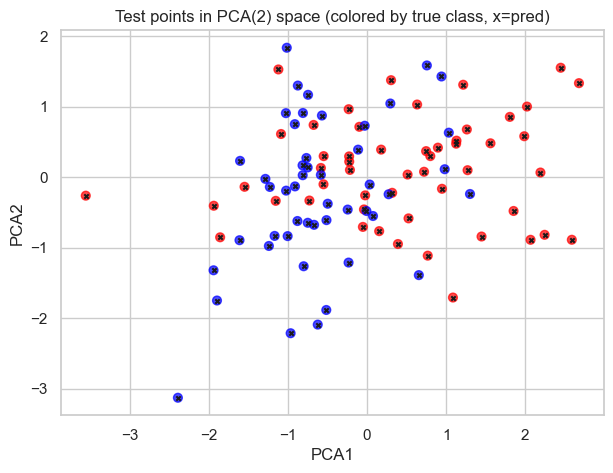

In [115]:
# scatter colored by true label, marker edge shows predicted (x)
y_test_pred_pca = svm_pca.predict(X_test_pca)
plt.figure(figsize=(7,5))
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap='bwr', s=40, label='true class', alpha=0.7)
# overlay predicted markers
for i in range(len(X_test_pca)):
    plt.scatter(X_test_pca[i,0], X_test_pca[i,1], marker='x', c='k', s=10)
plt.xlabel('PCA1'); plt.ylabel('PCA2')
plt.title('Test points in PCA(2) space (colored by true class, x=pred)')
plt.show()

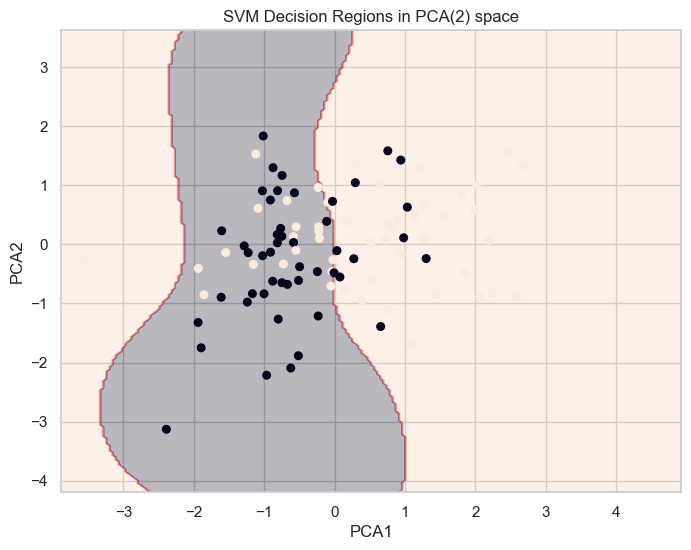

In [116]:
# Decision region (approx) in PCA space
xx_min, xx_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
yy_min, yy_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 200), np.linspace(yy_min, yy_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = svm_pca.predict(grid).reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, s=30)
plt.title("SVM Decision Regions in PCA(2) space")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.show()

**Step 7 — Hyperparameter tuning & optimization (GridSearchCV per kernel)**

In [117]:
# Step 7: Hyperparameter tuning - per-kernel GridSearchCV (smaller grids for speed)
param_grids = {
    'linear': {'svc__C': [0.01, 0.1, 1, 10]},
    'rbf': {'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto', 0.01, 0.1]},
    'poly': {'svc__C': [0.1, 1], 'svc__degree': [2,3], 'svc__gamma': ['scale','auto']}
}

results = []
for kernel, grid_params in param_grids.items():
    print(f"\nRunning GridSearch for kernel = {kernel}")
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel=kernel, probability=True, random_state=42))])
    grid = GridSearchCV(pipe, grid_params, cv=4, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred_best = best.predict(X_test)
    res = {
        'kernel': kernel,
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'test_acc': accuracy_score(y_test, y_pred_best),
        'test_prec': precision_score(y_test, y_pred_best, zero_division=0),
        'test_rec': recall_score(y_test, y_pred_best, zero_division=0),
        'test_f1': f1_score(y_test, y_pred_best, zero_division=0)
    }
    print("Best params:", grid.best_params_)
    print("Test F1:", res['test_f1'])
    results.append(res)

results_df = pd.DataFrame(results).set_index('kernel').sort_values('test_f1', ascending=False)
display(results_df)
# Save results
results_df.to_csv("svm_gridsearch_results.csv")
print("Saved grid search summary to svm_gridsearch_results.csv")



Running GridSearch for kernel = linear
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params: {'svc__C': 1}
Test F1: 0.7142857142857143

Running GridSearch for kernel = rbf
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'svc__C': 10, 'svc__gamma': 'scale'}
Test F1: 0.7663551401869159

Running GridSearch for kernel = poly
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params: {'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale'}
Test F1: 0.6601941747572816


,best_params,cv_f1,test_acc,test_prec,test_rec,test_f1
kernel,,,,,,
rbf,"{'svc__C': 10, 'svc__gamma': 'scale'}",0.765967,0.75,0.745455,0.788462,0.766355
linear,{'svc__C': 1},0.719905,0.72,0.760870,0.673077,0.714286
poly,"{'svc__C': 1, 'svc__degree': 3, 'svc__gamma': ...",0.710650,0.65,0.666667,0.653846,0.660194


Saved grid search summary to svm_gridsearch_results.csv


**Final model training, evaluation & comparison plot**

Best kernel by test F1: rbf
Best params: {'svc__C': 10, 'svc__gamma': 'scale'}

Final model metrics:
Accuracy: 0.75
Precision: 0.7454545454545455
Recall: 0.7884615384615384
F1-score: 0.7663551401869159
ROC AUC: 0.8068910256410257

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73        48
           1       0.75      0.79      0.77        52

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



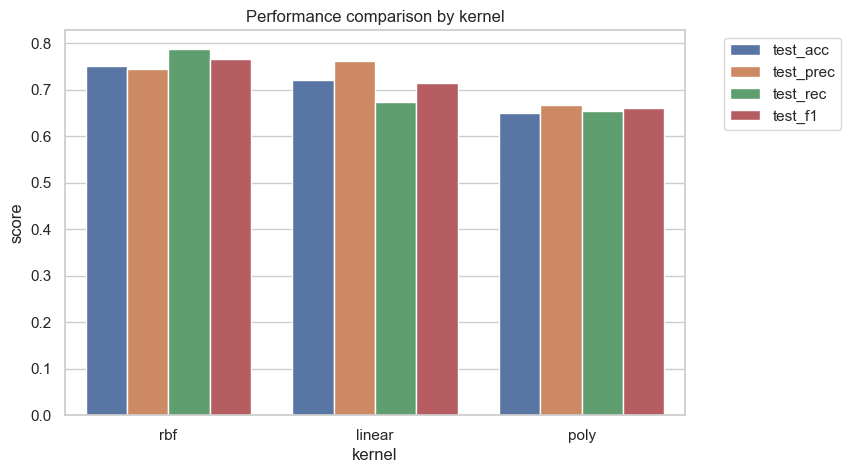

In [118]:
# Step 8: Choose best kernel by test F1 and retrain final model
best_kernel = results_df['test_f1'].idxmax()
best_params = results_df.loc[best_kernel, 'best_params']
print("Best kernel by test F1:", best_kernel)
print("Best params:", best_params)

# convert param names if they contain svc__ prefix
svc_kwargs = {}
for k, v in best_params.items():
    short = k.split('__')[-1]
    svc_kwargs[short] = v

final_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel=best_kernel, probability=True, random_state=42, **svc_kwargs))])
final_pipeline.fit(X_train, y_train)
y_final = final_pipeline.predict(X_test)
y_final_proba = final_pipeline.predict_proba(X_test)[:,1] if hasattr(final_pipeline.named_steps['svc'], "predict_proba") else None

print("\nFinal model metrics:")
print("Accuracy:", accuracy_score(y_test, y_final))
print("Precision:", precision_score(y_test, y_final, zero_division=0))
print("Recall:", recall_score(y_test, y_final, zero_division=0))
print("F1-score:", f1_score(y_test, y_final, zero_division=0))
if y_final_proba is not None:
    try:
        print("ROC AUC:", roc_auc_score(y_test, y_final_proba))
    except Exception:
        pass

print("\nClassification report:\n", classification_report(y_test, y_final, zero_division=0))

# Compare kernels summary plot
comp_df = results_df.reset_index()[['kernel','test_acc','test_prec','test_rec','test_f1']].melt(id_vars='kernel', var_name='metric', value_name='score')
plt.figure(figsize=(8,5))
sns.barplot(data=comp_df, x='kernel', y='score', hue='metric')
plt.title("Performance comparison by kernel")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()
